In [16]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# ===============================
# 1. Chargement et Exploration des Données
# ===============================


In [17]:
def load_data(filepath="../data/stages-votes.json"):
    """Charge le fichier JSON et retourne un DataFrame pandas."""
    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)
    return pd.DataFrame(data)

df = load_data()
print("Aperçu des données :")
display(df.head())
print("Informations sur les données :")
df.info()
print("Distribution des labels :")
print(df["sol"].value_counts())

df["text_length"] = df["phrase_text"].apply(lambda x: len(str(x)))
print("Longueur moyenne des descriptions :", df["text_length"].mean())

Aperçu des données :


,phrase_text,user,sol
0,Mission d accompagnement d' un public en situa...,p01,ko
1,Participer à la rédaction de la foire aux ques...,p01,ko
2,"Vente , rayonnage , étiquetage , encaissement",p01,ko
3,"Connaître les cultures de taxus baccata , assi...",p01,ko
4,observer le travail de l' IDE ou de l' AS et p...,p01,ok


Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397 entries, 0 to 1396
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   phrase_text  1397 non-null   object
 1   user         1397 non-null   object
 2   sol          1397 non-null   object
dtypes: object(3)
memory usage: 32.9+ KB
Distribution des labels :
sol
ko    826
ok    571
Name: count, dtype: int64
Longueur moyenne des descriptions : 200.60272011453114


# ===============================
# 2. Nettoyage des Données
# ===============================

In [18]:
# Détection des incohérences dans les labels
def majority_label(labels):
    return Counter(labels).most_common(1)[0][0]

df = df.groupby("phrase_text").agg({
    "sol": lambda x: majority_label(list(x)),
    "user": "first",
    "text_length": "first"
}).reset_index()

# Suppression des doublons exacts
df = df.drop_duplicates(subset=["phrase_text", "sol"]).reset_index(drop=True)
print(f"Nombre de lignes après nettoyage : {df.shape[0]}")

Nombre de lignes après nettoyage : 1327


# ===============================
# 3. Analyse Exploratoire des Données
# ===============================

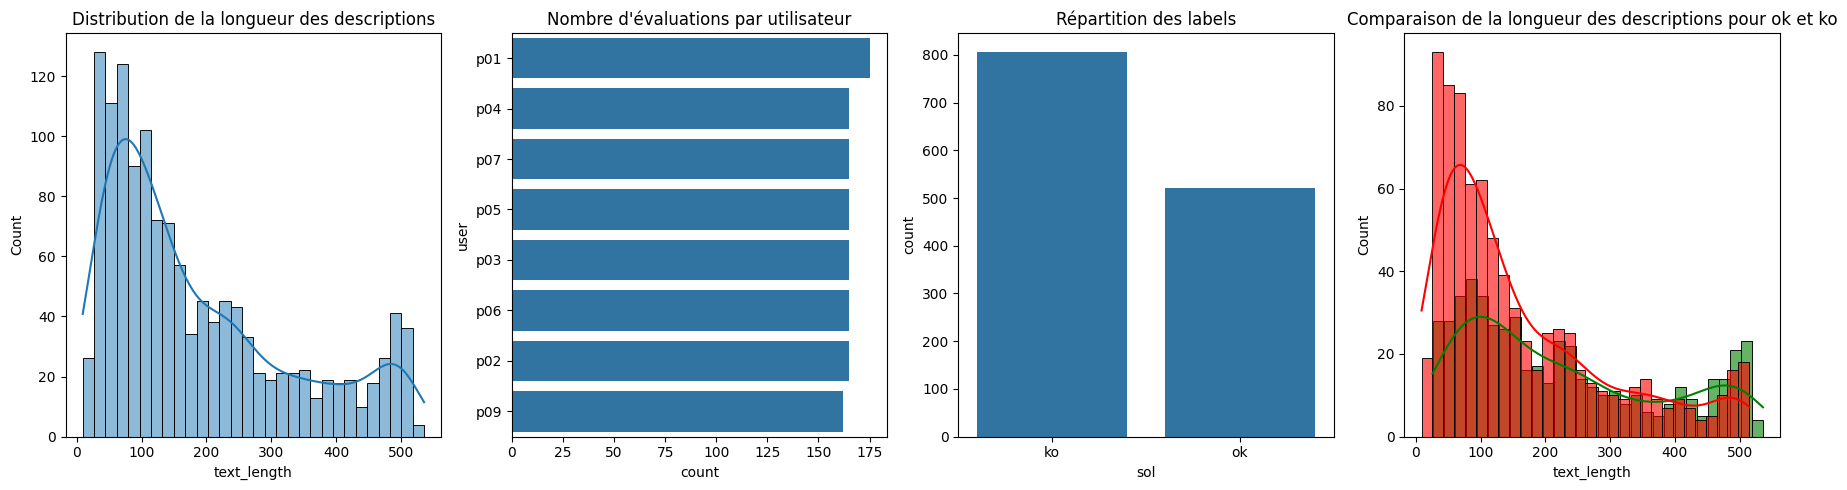

In [19]:
df_ok = df[df["sol"] == "ok"]
df_ko = df[df["sol"] == "ko"]

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

sns.histplot(df["text_length"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution de la longueur des descriptions")

sns.countplot(y=df["user"], order=df["user"].value_counts().index, ax=axes[1])
axes[1].set_title("Nombre d'évaluations par utilisateur")

sns.countplot(x=df["sol"], ax=axes[2])
axes[2].set_title("Répartition des labels")

# Histogramme superposé
sns.histplot(df_ok["text_length"], bins=30, kde=True, color="green", label="ok", alpha=0.6, ax=axes[3])
sns.histplot(df_ko["text_length"], bins=30, kde=True, color="red", label="ko", alpha=0.6,ax=axes[3])
axes[3].set_title("Comparaison de la longueur des descriptions pour ok et ko")

plt.tight_layout()
plt.show()

# ===============================
# 4. Entraînement des Modèles
# ===============================

In [25]:
# X = df["phrase_text"]
# y = df["sol"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# models = {
#     "Naïve Bayes": MultinomialNB(),
#     "Logistic Regression": LogisticRegression(max_iter=500),
#     "SVM": SVC(kernel="linear"),
#     "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
# }

# best_model, best_score = None, 0
# for model_name, model in models.items():
#     pipeline = Pipeline([
#         ("tfidf", TfidfVectorizer()),
#         ("clf", model)
#     ])
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"{model_name} - Accuracy: {accuracy:.4f}")
#     if accuracy > best_score:
#         best_model, best_score = pipeline, accuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split

# Séparer les features et la cible
X = df["phrase_text"]
y = df["sol"]

# Stratifier le split pour éviter un déséquilibre dans le jeu d'entraînement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(kernel="linear"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

best_model, best_score = None, 0
results = {}

for model_name, model in models.items():
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    results[model_name] = {
        "accuracy": accuracy,
        "balanced_accuracy": balanced_acc,
        "precision": precision,
        "recall": recall,
        "f1-score": f1
    }

    print(f"\n🚀 **{model_name}**")
    print(f"✅ Accuracy            : {accuracy:.4f}")
    print(f"⚖️  Balanced Accuracy : {balanced_acc:.4f}")
    print(f"🎯 Precision          : {precision:.4f}")
    print(f"🔄 Recall             : {recall:.4f}")
    print(f"🏆 F1-score           : {f1:.4f}")

    if f1 > best_score:
        best_model, best_score = pipeline, f1

joblib.dump(best_model, "../model/classifier.pkl")

# 📊 Matrice de confusion du meilleur modèle
y_pred = best_model.predict(X_test)
print("\n📉 Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))



🚀 **Naïve Bayes**
✅ Accuracy            : 0.6729
⚖️  Balanced Accuracy : 0.6093
🎯 Precision          : 0.6731
🔄 Recall             : 0.6729
🏆 F1-score           : 0.6379

🚀 **Logistic Regression**
✅ Accuracy            : 0.7030
⚖️  Balanced Accuracy : 0.6615
🎯 Precision          : 0.6979
🔄 Recall             : 0.7030
🏆 F1-score           : 0.6900

🚀 **SVM**
✅ Accuracy            : 0.6541
⚖️  Balanced Accuracy : 0.6300
🎯 Precision          : 0.6498
🔄 Recall             : 0.6541
🏆 F1-score           : 0.6514

🚀 **Random Forest**
✅ Accuracy            : 0.6992
⚖️  Balanced Accuracy : 0.6464
🎯 Precision          : 0.6994
🔄 Recall             : 0.6992
🏆 F1-score           : 0.6769

📉 Matrice de confusion :
[[138  24]
 [ 55  49]]


**Logistic Regression** est le modèle le plus équilibré :

- Meilleur F1-score (0.6900) → Bon compromis entre précision et rappel
- Meilleure Balanced Accuracy (0.6615) → Meilleur ajustement au déséquilibre
- Bonne précision et recall → Fiable pour éviter les erreurs de classification
- Le modèle a du mal à bien classer les "ok" (55 erreurs).
- Il fait moins d’erreurs en classant "ko" (24 erreurs).

--> **Solution possible** : Ajuster le seuil de décision ou utiliser un poids plus fort pour "ok" dans la loss function.

# ===============================
# 5. Optimisation et Sauvegarde du Meilleur Modèle
# ===============================

In [26]:
from sklearn.model_selection import GridSearchCV
import joblib

# 📌 Définition du pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression())
])

# 📌 Grille des hyperparamètres à tester
param_grid = {
    "tfidf__ngram_range": [(1,1)],  # Seulement des unigrammes (moins de bruit)
    "tfidf__max_features": [10000],  # Cap à 10K tokens
    "clf__C": [1, 10],  # On reste sur des valeurs raisonnables
    "clf__solver": ["liblinear"],  # Meilleur pour petits datasets
    "clf__max_iter": [1000]  # Permet la convergence
}


# 📌 Initialisation de la recherche avec validation croisée
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="f1_weighted", n_jobs=-1, verbose=2)

# 📌 Entraînement sur le jeu d'entraînement
grid_search.fit(X_train, y_train)

# 📌 Meilleurs hyperparamètres trouvés
print(f"🏆 Meilleurs paramètres : {grid_search.best_params_}")

# 📌 Entraîner le modèle final avec ces paramètres
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# 📌 Évaluation sur le jeu de test
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"✅ Accuracy après optimisation : {accuracy:.4f}")
print(f"⚖️ Balanced Accuracy : {balanced_acc:.4f}")
print(f"🏆 F1-score : {f1:.4f}")


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[CV] END clf__C=10, clf__max_iter=1000, clf__solver=liblinear, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END clf__C=1, clf__max_iter=1000, clf__solver=liblinear, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END clf__C=1, clf__max_iter=1000, clf__solver=liblinear, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END clf__C=1, clf__max_iter=1000, clf__solver=liblinear, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END clf__C=1, clf__max_iter=1000, clf__solver=liblinear, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END clf__C=1, clf__max_iter=1000, clf__solver=liblinear, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END clf__C=10, clf__max_iter=1000, clf__solver=liblinear, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__C=10, clf__max_iter=1000, clf__solver=l

L'otpimisation du modèle ne donne pas de meilleur résultats. 